In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.options.display.precision=2
np.random.seed(199)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# логин и пароль к базе
with open('pass4.txt', 'r') as lopa:
    myaccount = lopa.read()
myaccount = myaccount.split()
username = myaccount[0]
password = myaccount[1]

# порт хост и имя
hostname = 'spb99akl-adbm01'
port = '5432'
database_name = 'edw'

In [4]:
conection_string = f'postgresql://{username}:{password}@{hostname}:{port}/{database_name}'
engine = create_engine(conection_string)

In [20]:
events_sql = '''
SELECT counterid, "custom_parameters" -> 'user_id'  ->> 'value' as "user_id", timestamp, componentid
FROM ods_spa_metrics.events
WHERE counterid = 153 and 
componentid IN (
    'project card_RB_pressed',
    'init data_calculate_pressed',
    'results_page_opened')
AND events.eventtype = 3
AND to_timestamp(timestamp) between '2025-01-01 00:00:00'::timestamp  and '2025-10-21 23:55:00'::timestamp

'''
events = pd.read_sql(events_sql, engine)

In [21]:
events['event_time'] = pd.to_datetime(events['timestamp'], unit='s')

In [22]:
events

,counterid,user_id,timestamp,componentid,event_time
0,153,3a5ecd99-f5d0-4692-ab7f-899b024d5063,1747641802,init data_calculate_pressed,2025-05-19 08:03:22
1,153,bf6b880b-5469-4fe2-a278-22caa6cdb826,1747652441,init data_calculate_pressed,2025-05-19 11:00:41
2,153,e16b8511-d8a4-475e-8891-d6a75ea561a4,1748001286,init data_calculate_pressed,2025-05-23 11:54:46
3,153,tatarkina.as,1748352630,project card_RB_pressed,2025-05-27 13:30:30
4,153,fofanova.ea,1748353402,project card_RB_pressed,2025-05-27 13:43:22
...,...,...,...,...,...
6526,153,eeaf4c85-5af3-4ed5-942d-230f959920fb,1744718220,init data_calculate_pressed,2025-04-15 11:57:00
6527,153,eeaf4c85-5af3-4ed5-942d-230f959920fb,1744719134,init data_calculate_pressed,2025-04-15 12:12:14
6528,153,eeaf4c85-5af3-4ed5-942d-230f959920fb,1744719908,init data_calculate_pressed,2025-04-15 12:25:08
6529,153,8325de60-565d-4e5a-9c71-dd6263f05069,1745908240,project card_RB_pressed,2025-04-29 06:30:40


In [23]:
events.groupby('componentid').count()

,counterid,user_id,timestamp,event_time
componentid,,,,
init data_calculate_pressed,3907,3907,3907,3907
project card_RB_pressed,1815,1815,1815,1815
results_page_opened,809,608,809,809


In [24]:
def funeller(df, start_date, end_date, events=[], group_col=None, conversion_window_seconds=3600):
    if len(events) < 2:
        return print('Событий должно быть минимум 2')
    if len(events) >= 2:
        df_filtered = df[(df['event_time'] >= start_date) &
            (df['event_time'] <= end_date)
        ].copy()
        final_df = df_filtered[df_filtered['componentid'] == events[0]].copy().reset_index()
        final_df = final_df.rename(columns={'event_time': events[0]})
        final_df = final_df[['index', group_col, events[0]]]
        for i in range (1 ,len(events)):
            if i == 1:
                df_start = final_df[['index', group_col, events[0]]].copy()
            else:
                df_start = final_df[['index', group_col, events[i-1]]].copy()
            
            df_end = df_filtered[df_filtered['componentid'] == events[i]].copy()
            df_end = df_end.rename(columns={'event_time': events[i]})
            df_start = df_start.dropna(subset=[events[i-1]])
            merged = pd.merge_asof(
                df_end.sort_values(events[i],),
                df_start.sort_values(events[i-1]),
                left_on=events[i],
                right_on=events[i-1],
                by=group_col,
                direction='backward',
                tolerance=pd.Timedelta(seconds=conversion_window_seconds)
            )
            merged['conversion_time'] = (merged[events[i]] - merged[events[i-1]]).dt.total_seconds()
            merged = merged.sort_values('conversion_time')
            if group_col:
                merged = merged.dropna().drop_duplicates(subset=[group_col, events[i-1]], keep='first')
            else:
                merged = merged.dropna().drop_duplicates(subset=[events[i-1]], keep='first')
            final_df = final_df.merge(merged[[events[i], 'index', 'conversion_time']], on='index', how='left')
        final_df['total_conversion_time'] = (final_df[events[-1]] - final_df[events[0]]).dt.total_seconds()
        metrics = {}
        for i in events:
            metrics.update({i: int(final_df[i].notna().sum())})
        metrics.update({'mean_conversion_time': float(final_df['total_conversion_time'].mean()),
                       'median_conversion_time': float(final_df['total_conversion_time'].median())})
        return final_df, metrics

In [38]:
one, two = funeller(
    df=events,
    start_date='2025-03-01 00:00:00',
    end_date='2025-10-21 23:55:00',
    events=['project card_RB_pressed', 'init data_calculate_pressed', 'results_page_opened'],
    group_col='user_id',
    conversion_window_seconds=1800
)


display(two)

{'project card_RB_pressed': 1598,
 'init data_calculate_pressed': 619,
 'results_page_opened': 94,
 'mean_conversion_time': 527.7021276595744,
 'median_conversion_time': 333.0}

In [46]:
one

,index,user_id,project card_RB_pressed,init data_calculate_pressed,conversion_time_x,results_page_opened,conversion_time_y,total_conversion_time
0,3,tatarkina.as,2025-05-27 13:30:30,2025-05-27 13:30:33,3.00,NaT,NaN,NaN
1,4,fofanova.ea,2025-05-27 13:43:22,NaT,NaN,NaT,NaN,NaN
2,16,radchenko.va,2025-05-30 07:04:54,NaT,NaN,NaT,NaN,NaN
3,21,62025e2a-4a4c-408b-8dac-389a5b47c11b,2025-05-20 06:58:11,NaT,NaN,NaT,NaN,NaN
4,22,3a5ecd99-f5d0-4692-ab7f-899b024d5063,2025-05-21 11:28:43,NaT,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...
1593,6515,eeaf4c85-5af3-4ed5-942d-230f959920fb,2025-04-04 07:13:28,2025-04-04 07:20:43,435.00,NaT,NaN,NaN
1594,6520,eeaf4c85-5af3-4ed5-942d-230f959920fb,2025-04-21 14:33:24,NaT,NaN,NaT,NaN,NaN
1595,6521,3a5ecd99-f5d0-4692-ab7f-899b024d5063,2025-04-23 14:41:06,NaT,NaN,NaT,NaN,NaN
1596,6522,eeaf4c85-5af3-4ed5-942d-230f959920fb,2025-04-24 10:58:17,NaT,NaN,NaT,NaN,NaN


In [40]:
one['conversion_time_x'].median()

np.float64(40.0)

In [41]:
one['conversion_time_y'].median()

np.float64(192.0)

In [42]:
one['total_conversion_time'].median()

np.float64(333.0)

1598

In [43]:
display(one)

,index,user_id,project card_RB_pressed,init data_calculate_pressed,conversion_time_x,results_page_opened,conversion_time_y,total_conversion_time
0,3,tatarkina.as,2025-05-27 13:30:30,2025-05-27 13:30:33,3.00,NaT,NaN,NaN
1,4,fofanova.ea,2025-05-27 13:43:22,NaT,NaN,NaT,NaN,NaN
2,16,radchenko.va,2025-05-30 07:04:54,NaT,NaN,NaT,NaN,NaN
3,21,62025e2a-4a4c-408b-8dac-389a5b47c11b,2025-05-20 06:58:11,NaT,NaN,NaT,NaN,NaN
4,22,3a5ecd99-f5d0-4692-ab7f-899b024d5063,2025-05-21 11:28:43,NaT,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...
1593,6515,eeaf4c85-5af3-4ed5-942d-230f959920fb,2025-04-04 07:13:28,2025-04-04 07:20:43,435.00,NaT,NaN,NaN
1594,6520,eeaf4c85-5af3-4ed5-942d-230f959920fb,2025-04-21 14:33:24,NaT,NaN,NaT,NaN,NaN
1595,6521,3a5ecd99-f5d0-4692-ab7f-899b024d5063,2025-04-23 14:41:06,NaT,NaN,NaT,NaN,NaN
1596,6522,eeaf4c85-5af3-4ed5-942d-230f959920fb,2025-04-24 10:58:17,NaT,NaN,NaT,NaN,NaN


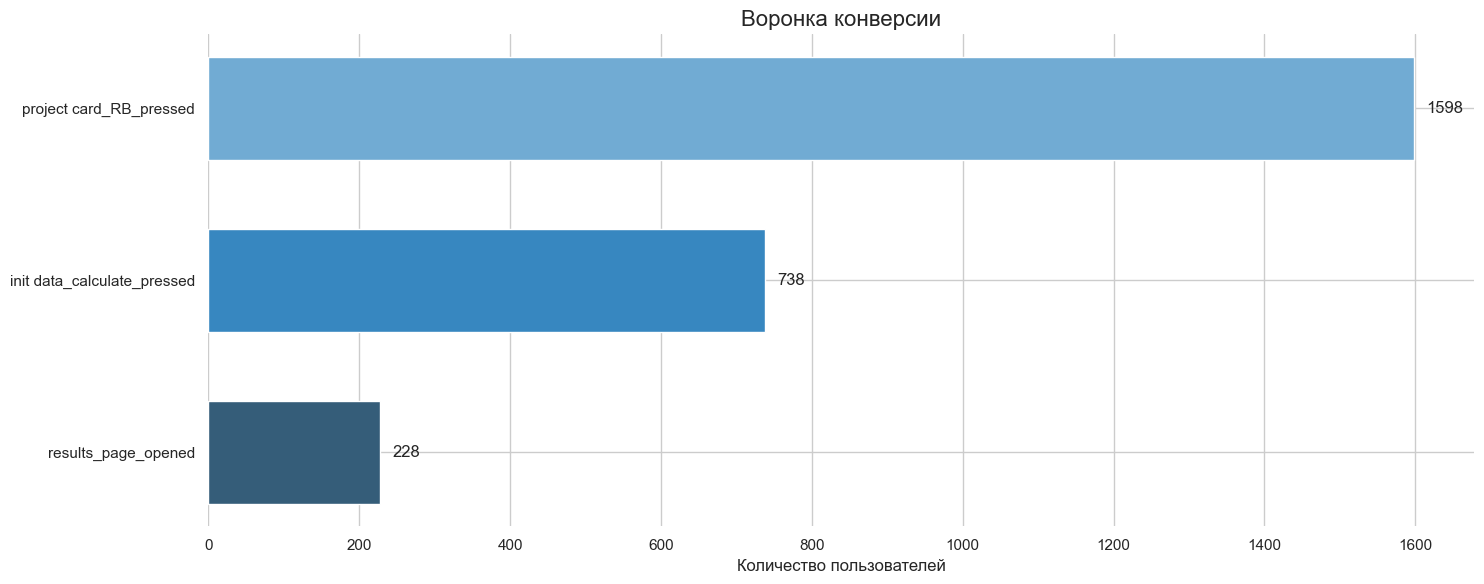

In [28]:
steps = []
values = []

for key, value in two.items():
    if 'mean_conversion_time' in key or 'median_conversion_time' in key:
        break
    steps.append(key)
    values.append(value)

# Настройка стиля
sns.set_theme(style="whitegrid")

# Построение воронки (горизонтальная barh)
y_pos = np.arange(len(steps))
colors = sns.color_palette("Blues_d", len(steps))  # Градиент от темного к светлому

plt.figure(figsize=(15, 6))
bars = plt.barh(y_pos, values, color=colors, edgecolor='white', height=0.6)

# Оформление
plt.yticks(y_pos, steps)
plt.xlabel("Количество пользователей")
plt.title("Воронка конверсии", fontsize=16)
plt.gca().invert_yaxis()  # Первый шаг сверху вниз

# Добавление значений на бары
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(values)*0.01, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center')

# Улучшение внешнего вида
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Показать график
plt.show()

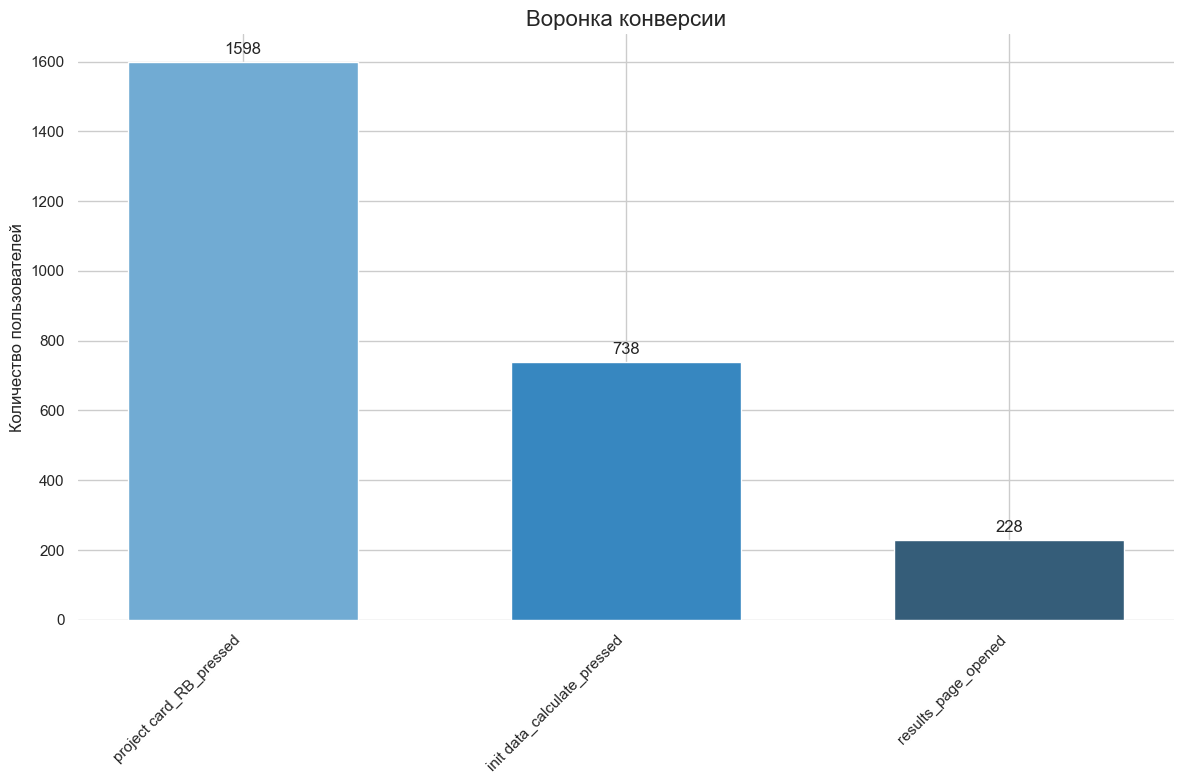

In [29]:
# Настройка стиля
sns.set_theme(style="whitegrid")

# Создаем фигуру и оси
plt.figure(figsize=(12, 8))

# Позиции для баров (горизонтальные позиции)
x_pos = np.arange(len(steps))
colors = sns.color_palette("Blues_d", len(steps))  # Градиент от темного к светлому

# Создаем вертикальные бары (но будем их визуально оформлять как воронку)
bars = plt.bar(x_pos, values, color=colors, edgecolor='white', width=0.6)

# Оформление
plt.xticks(x_pos, steps, rotation=45, ha='right')
plt.ylabel("Количество пользователей")
plt.title("Воронка конверсии", fontsize=16)

# Добавление значений на бары
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(values)*0.01,
             f'{int(height)}', ha='center', va='bottom')

# Улучшение внешнего вида
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Показать график
plt.show()